## Convolutional Neural Network (CNN)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer

# Load the data
train_df = pd.read_csv('engineered_csv/train_combined_features.csv')
test_df = pd.read_csv('engineered_csv/test_combined_features.csv')

# Define feature groups
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']

engineered_numerical_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

engineered_categorical_features = ['Size_Class', 'Speed_Tier']

image_features = ['RGB_Mean', 'RGB_Std', 'RGB_Max', 'LBP_Mean', 'LBP_Std', 'LBP_Max', 'CNN_Mean', 'CNN_Std', 'CNN_Max']

# Combine all features
all_numerical_features = original_features + engineered_numerical_features + image_features
all_features = all_numerical_features + engineered_categorical_features

# Create preprocessing pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, all_numerical_features),
        ('cat', categorical_transformer, engineered_categorical_features)
    ])

# Fit the preprocessor on the training data and transform both train and test
X_train = preprocessor.fit_transform(train_df[all_features])
X_test = preprocessor.transform(test_df[all_features])

# Prepare target variables
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']

# Primary Type encoding and categorical conversion
le_primary = LabelEncoder()
y_train_primary_encoded = le_primary.fit_transform(y_train_primary)
y_test_primary_encoded = le_primary.transform(y_test_primary)
y_train_primary_cat = to_categorical(y_train_primary_encoded)
y_test_primary_cat = to_categorical(y_test_primary_encoded)

# Generation encoding and categorical conversion
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

le_generation = LabelEncoder()
y_train_generation_encoded = le_generation.fit_transform(y_train_generation)
y_test_generation_encoded = le_generation.transform(y_test_generation)
y_train_generation_cat = to_categorical(y_train_generation_encoded, num_classes=9)
y_test_generation_cat = to_categorical(y_test_generation_encoded, num_classes=9)

# Both types multi-label classification (already in binary format)
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

print("y_train_both_bin shape:", y_train_both_bin.shape)
print("y_test_both_bin shape:", y_test_both_bin.shape)

# Get feature names after preprocessing
feature_names = (
    all_numerical_features +
    preprocessor.named_transformers_['cat'].get_feature_names_out(engineered_categorical_features).tolist()
)

print("Primary Type shapes:", y_train_primary_encoded.shape, y_test_primary_encoded.shape)
print("Generation shapes:", y_train_generation_encoded.shape, y_test_generation_encoded.shape)
print("Both Types shapes:", y_train_both_bin.shape, y_test_both_bin.shape)

# print("X_train shape:", X_train.shape)
# print("X_test shape:", X_test.shape)
# print("Number of features after preprocessing:", len(feature_names))

# print("Unique categories in train set:", np.unique(y_train_primary))
# print("Unique categories in test set:", np.unique(y_test_primary))

# train_categories = set(y_train_primary)
# test_categories = set(y_test_primary)
# missing_categories = test_categories - train_categories

# if missing_categories:
#     print("Categories in test set but not in train set:", missing_categories)

y_train_both_bin shape: (820, 18)
y_test_both_bin shape: (205, 18)
Primary Type shapes: (820,) (205,)
Generation shapes: (820,) (205,)
Both Types shapes: (820, 18) (205, 18)


In [2]:
import os
from PIL import Image
import numpy as np

def load_and_preprocess_image(row, mode='train', target_size=(224, 224)):
    name = row['Name']
    gen = int(row['Generation'])
    
    base_dir = 'pokemon_train_images' if mode == 'train' else 'pokemon_test_images'
    img_path = os.path.join(base_dir, f'gen_{gen}.0', f'{name}.png')
    
    try:
        img = Image.open(img_path).convert('RGBA')
        background = Image.new('RGBA', img.size, (255, 255, 255, 255))
        img = Image.alpha_composite(background, img)
        
        data = np.array(img)
        r, g, b, a = data.T
        white_areas = (r == 255) & (g == 255) & (b == 255)
        data[..., :][white_areas.T] = (255, 255, 255, 0)
        
        img = Image.fromarray(data)
        img = img.resize(target_size)
        
        img_array = np.array(img.convert('RGB')) / 255.0
        
        return img_array
    except Exception as e:
        print(f"Error processing {name} ({mode}): {str(e)}")
        return None

# Load train images
X_train_img = []
for _, row in train_df.iterrows():
    img = load_and_preprocess_image(row, mode='train')
    if img is not None:
        X_train_img.append(img)
X_train_img = np.array(X_train_img)

# Load test images
X_test_img = []
for _, row in test_df.iterrows():
    img = load_and_preprocess_image(row, mode='test')
    if img is not None:
        X_test_img.append(img)
X_test_img = np.array(X_test_img)

# Debugging print statements
print("Shape of X_train_img:", X_train_img.shape)
print("Type of X_train_img:", type(X_train_img))
print("Shape of X_test_img:", X_test_img.shape)
print("Type of X_test_img:", type(X_test_img))
print("First element of X_train_img shape:", X_train_img[0].shape)
print("First element of X_test_img shape:", X_test_img[0].shape)

Shape of X_train_img: (820, 224, 224, 3)
Type of X_train_img: <class 'numpy.ndarray'>
Shape of X_test_img: (205, 224, 224, 3)
Type of X_test_img: <class 'numpy.ndarray'>
First element of X_train_img shape: (224, 224, 3)
First element of X_test_img shape: (224, 224, 3)


Augmented images for Pokémon 1:


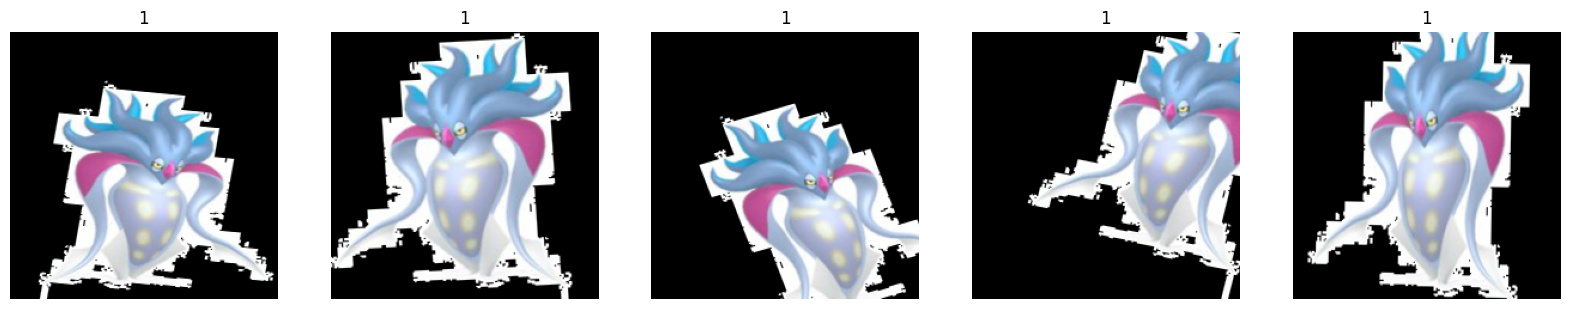

Augmented images for Pokémon 2:


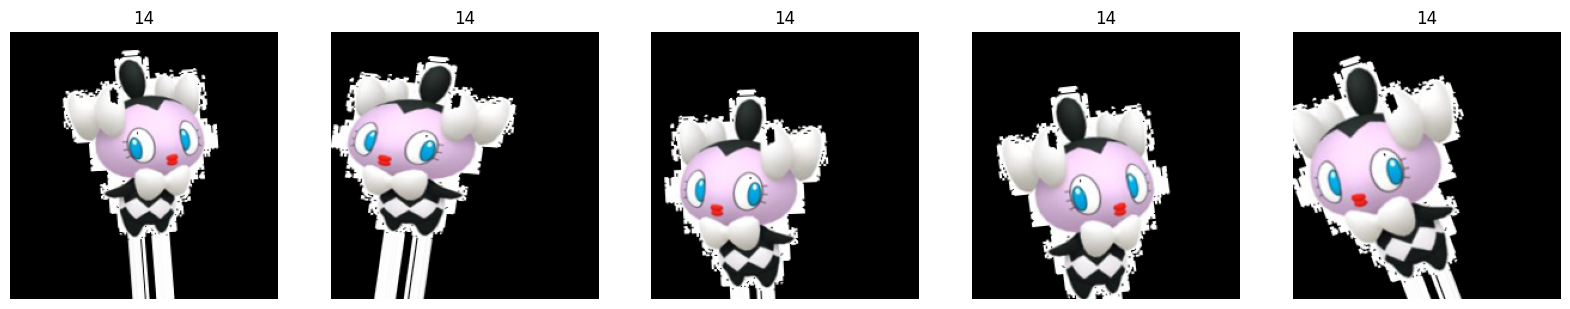

Augmented images for Pokémon 3:


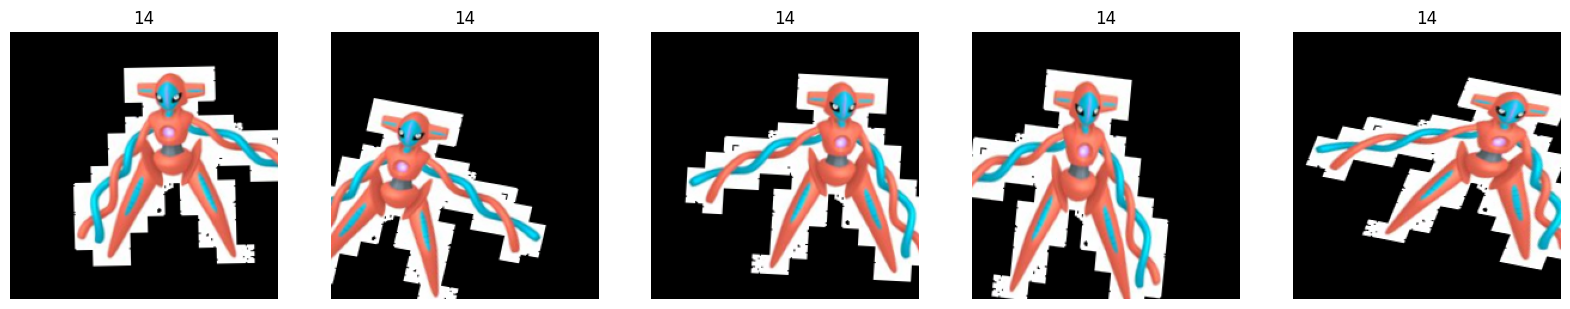

Augmented images for Pokémon 4:


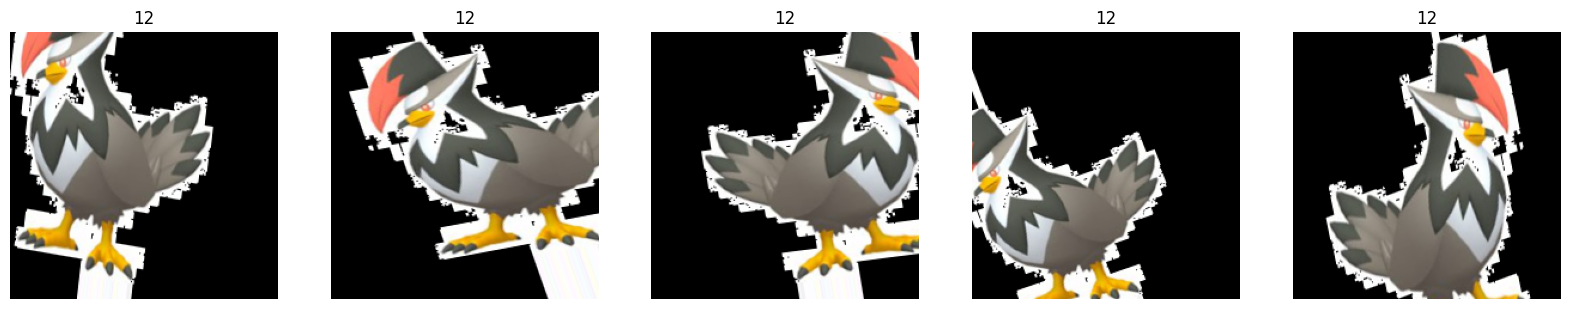

Augmented images for Pokémon 5:


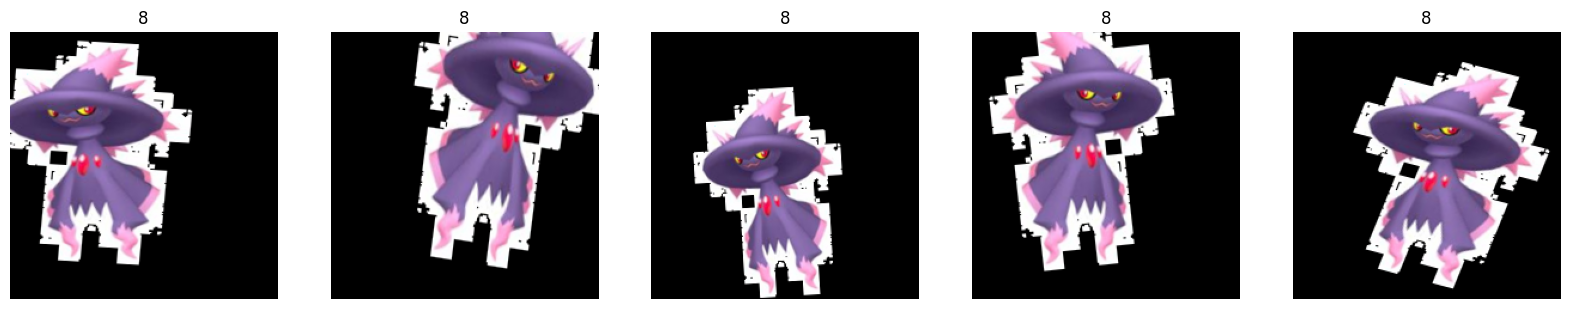

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2
# )
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.2,
    brightness_range=[0.8,1.2]
)

# Visualize some augmented images
def plot_augmented_images(X, y, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    X = np.expand_dims(X, 0)  # Add batch dimension
    y = np.array([y])  # Convert to numpy array
    for i in range(num_images):
        aug_img = next(datagen.flow(X, y))[0].astype(np.float32)
        axes[i].imshow(aug_img[0])
        axes[i].axis('off')
        axes[i].set_title(str(y[0]))  # Convert to string to ensure it can be displayed
    plt.show()

# Ensure X_train_img is a numpy array and y_train_primary is numerical
X_train_img = np.array(X_train_img)
y_train_primary = pd.Categorical(y_train_primary).codes

# Plot augmented images
num_pokemon_to_show = 5
for i in range(num_pokemon_to_show):
    print(f"Augmented images for Pokémon {i+1}:")
    plot_augmented_images(X_train_img[i], y_train_primary[i])
    plt.show()


In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate

def create_pokemon_cnn(img_shape, num_features, num_primary_types, num_total_types, num_generations):
    # Image input branch
    img_input = Input(shape=img_shape, name='image_input')
    x = Conv2D(32, (3, 3), activation='relu')(img_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)

    # Numerical features branch
    num_input = Input(shape=(num_features,), name='numerical_input')
    y = Dense(32, activation='relu')(num_input)

    # Combine branches
    combined = concatenate([x, y])
    z = Dense(64, activation='relu')(combined)
    z = Dropout(0.5)(z)

    # Output layers with explicit names
    primary_type = Dense(num_primary_types, activation='softmax', name='primary_type')(z)
    both_types = Dense(num_total_types, activation='sigmoid', name='both_types')(z)
    generation = Dense(num_generations, activation='softmax', name='generation')(z)

    # Create model with explicitly named outputs
    model = Model(
        inputs={'image_input': img_input, 'numerical_input': num_input},
        outputs={
            'primary_type': primary_type,
            'both_types': both_types,
            'generation': generation
        },
        name='pokemon_classifier'
    )
    return model

X_train_img = X_train_img.astype('float32')
X_train = X_train.astype('float32')
y_train_primary_cat = y_train_primary_cat.astype('float32')
y_train_both_bin = y_train_both_bin.astype('float32')  # Convert from int64 to float32
y_train_generation_cat = y_train_generation_cat.astype('float32')

img_shape = X_train_img[0].shape
num_features = X_train.shape[1]
num_primary_types = len(np.unique(y_train_primary))
num_total_types = y_train_both_bin.shape[1]
num_generations = y_train_generation_cat.shape[1]  # Should be 9

print(num_features)
print(num_generations)
print(num_primary_types)
print(num_total_types)




model = create_pokemon_cnn(img_shape, num_features, num_primary_types, num_total_types, num_generations)
model.compile(optimizer='adam',
              loss={'primary_type': 'categorical_crossentropy',
                    'both_types': 'binary_crossentropy',
                    'generation': 'categorical_crossentropy'},
              loss_weights={'primary_type': 1.0, 'both_types': 1.0, 'generation': 1.0},
              metrics={
        'primary_type': ['accuracy'],
        'both_types': ['accuracy'],
        'generation': ['accuracy']
    })

print("Model output shapes:")
print("Primary type output shape:", model.get_layer('primary_type').output.shape)  # (None, 18)
print("Both types output shape:", model.get_layer('both_types').output.shape)     # (None, 18)
print("Generation output shape:", model.get_layer('generation').output.shape)      # (None, 9)

print("\nTarget shapes:")
print("y_train_primary_cat shape:", y_train_primary_cat.shape)
print("y_train_both_bin shape:", y_train_both_bin.shape)
print("y_train_generation_cat shape:", y_train_generation_cat.shape)

model.summary()

42
9
18
18
Model output shapes:
Primary type output shape: (None, 18)
Both types output shape: (None, 18)
Generation output shape: (None, 9)

Target shapes:
y_train_primary_cat shape: (820, 18)
y_train_both_bin shape: (820, 18)
y_train_generation_cat shape: (820, 9)


Model: "pokemon_classifier"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 222, 222,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 111, 111,  │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │     18,496 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 54, 54,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 52, 52,    │     36,928 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_4 (Flatten) │ (None, 173056)    │          0 │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 42)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │ 11,075,648 │ flatten_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 32)        │      1,376 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 96)        │          0 │ dense_12[0][0],   │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │      6,208 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ both_types (Dense)  │ (None, 18)        │      1,170 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generation (Dense)  │ (None, 9)         │        585 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ primary_type        │ (None, 18)        │      1,170 │ dropout_4[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,142,477 (42.51 MB)

 Trainable params: 11,142,477 (42.51 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Print shapes for verification
print("X_train_img shape:", X_train_img.shape)
print("X_train shape:", X_train.shape)
print("y_train_primary_cat shape:", y_train_primary_cat.shape)
print("y_train_both_bin shape:", y_train_both_bin.shape)
print("y_train_generation_cat shape:", y_train_generation_cat.shape)

# Set up callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)
model_checkpoint = ModelCheckpoint(
    'best_pokemon_model.keras', 
    save_best_only=True
)

print("\nModel output shapes:")
for layer in model.outputs:
    print(f"{layer.name} shape:", layer.shape)

print("\nTarget shapes:")
print("Primary type shape:", y_train_primary_cat.shape)
print("Both types shape:", y_train_both_bin.shape)
print("Generation shape:", y_train_generation_cat.shape)

print("\nLayer names:")
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Dense):
        print(layer.name) 
        
print("X_train_img dtype:", X_train_img.dtype)
print("X_train dtype:", X_train.dtype)
print("y_train_primary_cat dtype:", y_train_primary_cat.dtype)
print("y_train_both_bin dtype:", y_train_both_bin.dtype)
print("y_train_generation_cat dtype:", y_train_generation_cat.dtype)

# Verify the exact data type of the output layers
print("Primary type layer output dtype:", model.get_layer('primary_type').output.dtype)
print("Both types layer output dtype:", model.get_layer('both_types').output.dtype)
print("Generation layer output dtype:", model.get_layer('generation').output.dtype)

print("\nModel output names:")
for output in model.outputs:
    print(output.name)

# Train the model
history = model.fit(
    {'image_input': X_train_img, 'numerical_input': X_train},
    {
        'primary_type': y_train_primary_cat,
        'both_types': y_train_both_bin,
        'generation': y_train_generation_cat
    },
    validation_split=0.2,
    epochs=5,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)

X_train_img shape: (820, 224, 224, 3)
X_train shape: (820, 42)
y_train_primary_cat shape: (820, 18)
y_train_both_bin shape: (820, 18)
y_train_generation_cat shape: (820, 9)

Model output shapes:
keras_tensor_76 shape: (None, 18)
keras_tensor_77 shape: (None, 9)
keras_tensor_75 shape: (None, 18)

Target shapes:
Primary type shape: (820, 18)
Both types shape: (820, 18)
Generation shape: (820, 9)

Layer names:
dense_12
dense_13
dense_14
both_types
generation
primary_type
X_train_img dtype: float32
X_train dtype: float32
y_train_primary_cat dtype: float32
y_train_both_bin dtype: float32
y_train_generation_cat dtype: float32
Primary type layer output dtype: float32
Both types layer output dtype: float32
Generation layer output dtype: float32

Model output names:
keras_tensor_76
keras_tensor_77
keras_tensor_75
Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - both_types_accuracy: 0.0569 - both_types_loss: 0.6642 - generation_accuracy: 0.1200 - generation_loss: 2.3621 - loss: 5.9611 - pri

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model('best_pokemon_model.keras')

# Evaluate on test set
test_loss = best_model.evaluate(
    [X_test_img, X_test],
    {
        'primary_type': y_test_primary_cat,
        'both_types': y_test_both_bin,
        'generation': y_test_generation_cat
    },
    verbose=1
)

# Make predictions for all outputs
predictions = best_model.predict([X_test_img, X_test])

# Primary Type predictions
primary_pred = np.argmax(predictions['primary_type'], axis=1)
primary_true = np.argmax(y_test_primary_cat, axis=1)

# Both Types predictions (using 0.5 threshold for binary classification)
both_pred = (predictions['both_types'] > 0.5).astype(int)
both_true = y_test_both_bin

# Generation predictions
gen_pred = np.argmax(predictions['generation'], axis=1)
gen_true = np.argmax(y_test_generation_cat, axis=1)

# Print classification reports
print("\nPrimary Type Classification Report:")
print(classification_report(
    primary_true, 
    primary_pred, 
    target_names=np.unique(y_test_primary)
))

print("\nBoth Types Classification Report:")
print(classification_report(
    both_true, 
    both_pred,
    target_names=mlb.classes_
))

print("\nGeneration Classification Report:")
print(classification_report(
    gen_true, 
    gen_pred,
    target_names=[f"Gen {i+1}" for i in range(9)]
))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - both_types_accuracy: 0.0680 - both_types_loss: 0.3071 - generation_accuracy: 0.2893 - generation_loss: 1.8306 - loss: 4.9494 - primary_type_accuracy: 0.1458 - primary_type_loss: 2.8170
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step

Primary Type Classification Report:
              precision    recall  f1-score   support

         Bug       0.12      0.18      0.14        17
        Dark       0.00      0.00      0.00         9
      Dragon       0.00      0.00      0.00         7
    Electric       0.00      0.00      0.00        12
       Fairy       0.00      0.00      0.00         6
    Fighting       0.00      0.00      0.00         8
        Fire       0.30      0.23      0.26        13
      Flying       0.00      0.00      0.00         2
       Ghost       0.00      0.00      0.00         7
       Grass       0.13      0.20      0.16        20
      Ground       0.00      0.00      0.00         8
         Ice       0.00      0.00      0.00      

/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/marvinchen/Desktop/IW/cos-independent-work/cos397/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

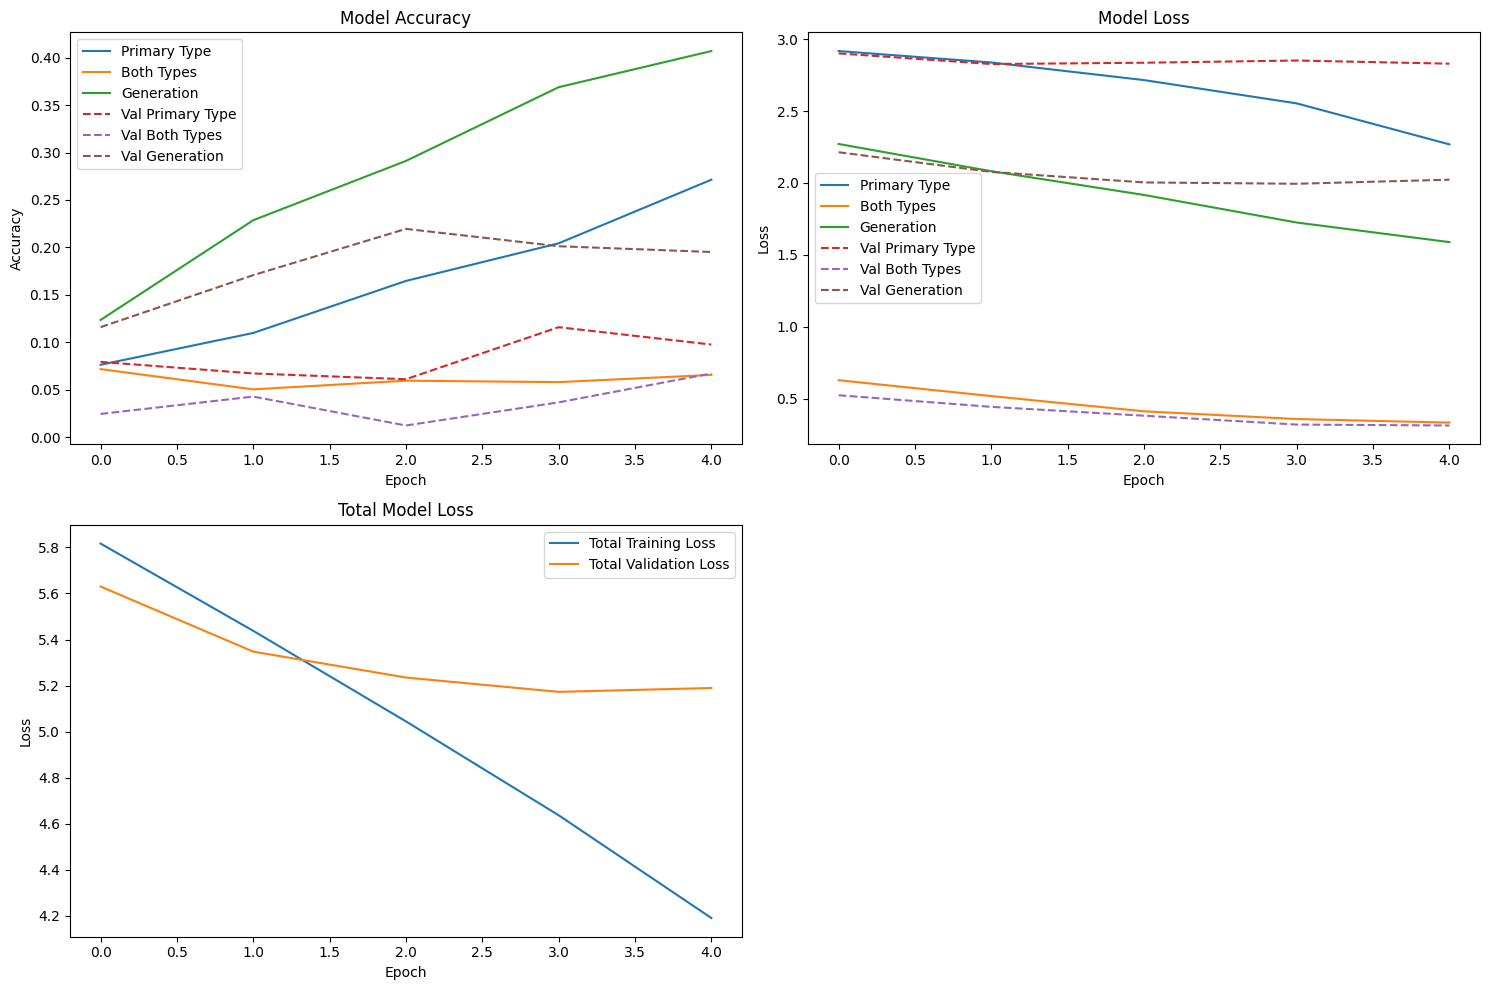

In [23]:
plt.figure(figsize=(15, 10))

# Accuracy plots
plt.subplot(2, 2, 1)
plt.plot(history.history['primary_type_accuracy'], label='Primary Type')
plt.plot(history.history['both_types_accuracy'], label='Both Types')
plt.plot(history.history['generation_accuracy'], label='Generation')
plt.plot(history.history['val_primary_type_accuracy'], label='Val Primary Type', linestyle='--')
plt.plot(history.history['val_both_types_accuracy'], label='Val Both Types', linestyle='--')
plt.plot(history.history['val_generation_accuracy'], label='Val Generation', linestyle='--')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plots
plt.subplot(2, 2, 2)
plt.plot(history.history['primary_type_loss'], label='Primary Type')
plt.plot(history.history['both_types_loss'], label='Both Types')
plt.plot(history.history['generation_loss'], label='Generation')
plt.plot(history.history['val_primary_type_loss'], label='Val Primary Type', linestyle='--')
plt.plot(history.history['val_both_types_loss'], label='Val Both Types', linestyle='--')
plt.plot(history.history['val_generation_loss'], label='Val Generation', linestyle='--')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Total loss plot
plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label='Total Training Loss')
plt.plot(history.history['val_loss'], label='Total Validation Loss')
plt.title('Total Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import save_model

# Save the final model
model.save('final_pokemon_model.keras')
print("Final model saved as 'final_pokemon_model.keras'")